In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data import
Anndata objects : obs x variables. In other words, cells x genes. 

At its core, an AnnData object stores a sparse or dense matrix (the count matrix in the case of scRNA-Seq) in X. This matrix has the dimensions of obs_names x var_names where the **obs (=observations) correspond to the cells’ barcodes and the var (=variables) correspond to the gene identifiers**. This matrix X is surrounded by Pandas DataFrames obs and var which save annotations of cells and genes respectively.

`adata.X` is what you are currently working with. Assign `adata.layers["normalized"]` to adata.X if you wanna work with normalized counts. `adata.X = adata.layers["raw"]` for the raw.

For more info, go to https://www.sc-best-practices.org/introduction/analysis_tools.html

##### For Tiago's data
Anndata object with QC metrics already calculated:

`n_genes_by_counts` (or just n_genes?) is the number of genes with a positive count within a given cell (or genes per barcode). 

`total counts` is the total number of counts for a given cell (or counts per barcode). 

So n_genes x total_counts would just be how many counts vs how many genes in each cell. Measures count depth. 


Also, it looks like its been filtered already? Based off these graphs.


In [2]:
neuruloids = sc.read_h5ad("data/GSE224404_posterior_neuruloid_data_file.h5ad")
print(neuruloids)

print(neuruloids.obs)
print(neuruloids.var)
print(neuruloids.obs['sample'])

AnnData object with n_obs × n_vars = 7792 × 33538
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet', 'doublet_score', 'sample'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2'
                    n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGTGGAAAG-1     5331               5331       29928.0           2698.0   
AAACGAAAGACGCCCT-1     3505               3505       16923.0           1817.0   
AAACGAACACACTTAG-1     6455               6455       39010.0           2837.0   
AAACGAAGTCATCCGG-1     3389               3389       12569.0            959.0   
AAACGCTAGAGCATAT-1     3574               3574       13754.0           1764.0   
...                     ...         

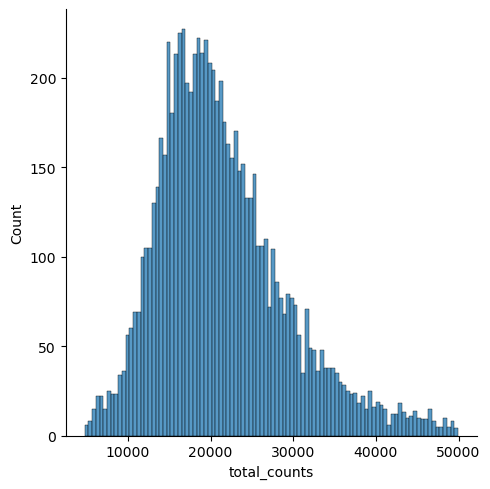

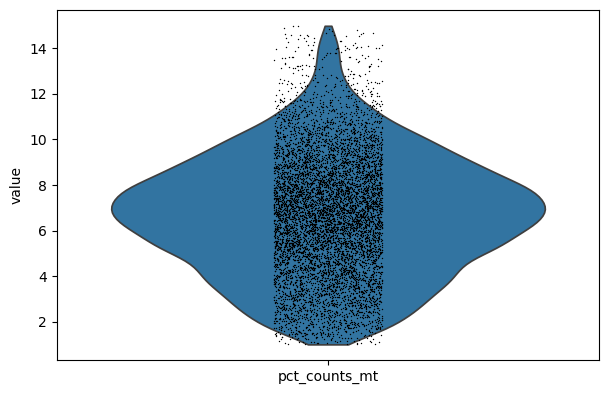

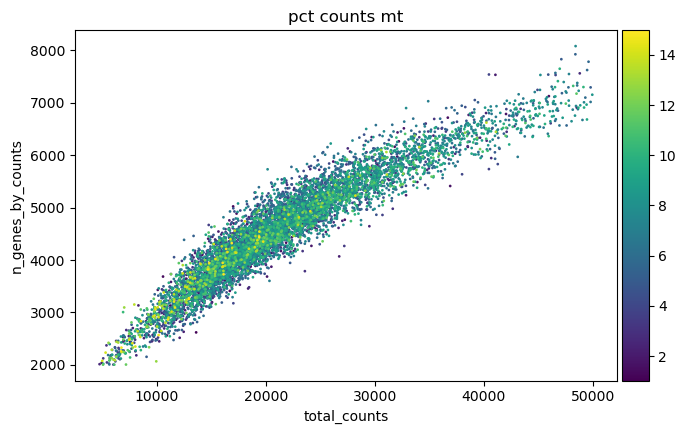

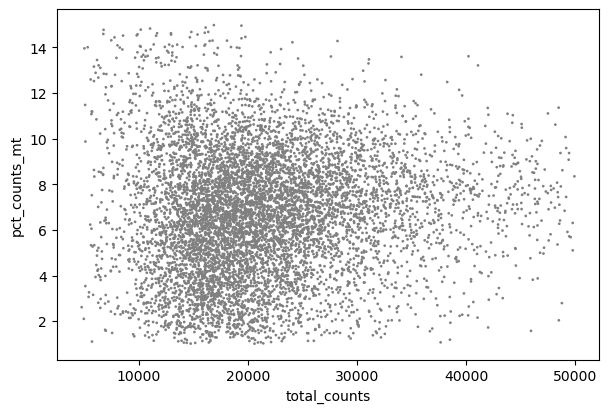

In [3]:
# Quality control plots
p1 = sns.displot(neuruloids.obs["total_counts"], bins=100, kde=False) #number of cells which has each total count. 
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(neuruloids, "pct_counts_mt")
p3 = sc.pl.scatter(neuruloids, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
p4 = sc.pl.scatter(neuruloids, "total_counts", "pct_counts_mt")

In [4]:
# filter for genes which appear in at least 5 cells
print(f"Total number of genes: {neuruloids.n_vars}")
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(neuruloids, min_cells=5)
print(f"Number of genes after cell filter: {neuruloids.n_vars}")

Total number of genes: 33538
Number of genes after cell filter: 21786


In [5]:
sc.pp.scale(neuruloids, max_value=10.0, copy=True)
sc.pp.pca(neuruloids, n_comps=30, copy=True)
sc.pp.neighbors(neuruloids, n_neighbors=15, n_pcs=30)
sc.tl.umap(neuruloids)

print(neuruloids)

/Users/yitingloo/miniforge3/envs/cellpose/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 21786 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/Users/yitingloo/miniforge3/envs/cellpose/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnnData object with n_obs × n_vars = 7792 × 21786
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet', 'doublet_score', 'sample'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'n_cells'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


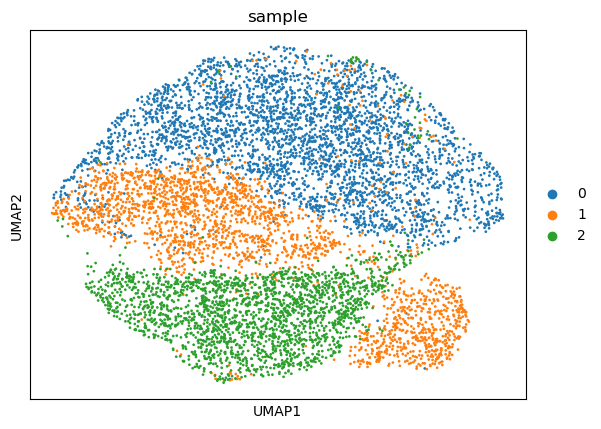

In [6]:
sc.pl.umap(neuruloids, color="sample", use_raw=False) #Three samples ( 0, 1, 2)

In [7]:
# Isolate the control sample
control = neuruloids[neuruloids.obs['sample'] == '0']
print(neuruloids)
print(control)

#--- Normalisation --- to correct for differences in sequencing depth between cells

control.layers['raw'] = control.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(control, target_sum=10000, exclude_highly_expressed=True)
# Logarithmize the data
sc.pp.log1p(control)

# new layer for normalised data
control.layers['norm'] = control.X.copy() 
# control.X is the current data matrix. Layers norm and raw are added to the adata object. 
# These layers can be assigned to the X matrix to switch between the raw and normalised data.

AnnData object with n_obs × n_vars = 7792 × 21786
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet', 'doublet_score', 'sample'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'n_cells'
    uns: 'pca', 'neighbors', 'umap', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
View of AnnData object with n_obs × n_vars = 3422 × 21786
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet', 'doublet_score', 'sample'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_c

/var/folders/l6/7jpz7klj03q1vh5gplwyx4vm0000gn/T/ipykernel_24643/3793048537.py:8: ImplicitModificationWarning: Setting element `.layers['raw']` of view, initializing view as actual.
  control.layers['raw'] = control.X.copy()


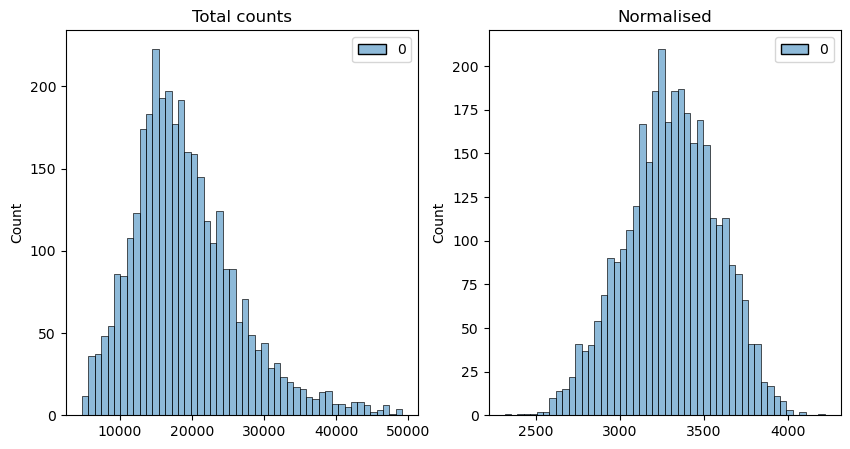

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(control.layers['raw'].sum(1), bins=50, kde=False, ax=axes[0]) 
# sum along axis 1 - sum of each row
# this layer is just a cells/genes matrix. the numbers are the counts of each gene in a cell.
# therefore, the sum of each row is the total counts of each cell. This would be the same as the total_counts column in the obs dataframe.
axes[0].set_title("Total counts")
p2 = sns.histplot(control.layers["norm"].sum(1), bins=50, kde=False, ax=axes[1])
axes[1].set_title("Normalised")
plt.show()
# x = control.layers["norm"]


## Feature selection
Single-cell RNA-seq datasets usually contain up to 30,000 genes and so far we only removed genes that are not detected in at least 20 cells. However, many of the remaining genes are not informative and contain mostly zero counts. 

Therefore, a standard preprocessing pipeline involves the step of feature selection which aims to exclude uninformative genes which might not represent meaningful biological variation across samples.

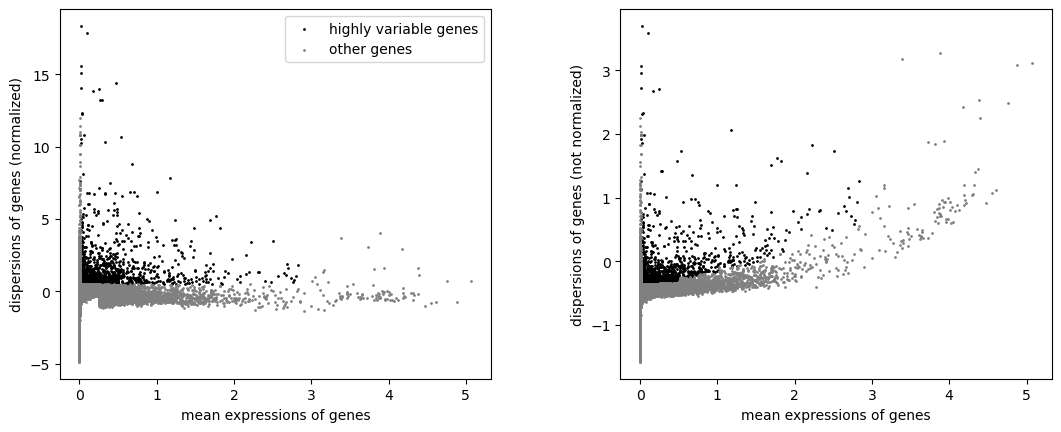

In [9]:
sc.pp.highly_variable_genes(control)

sc.pl.highly_variable_genes(control)

control_2 =  control[:, control.var.highly_variable]

In [10]:
control

AnnData object with n_obs × n_vars = 3422 × 21786
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet', 'doublet_score', 'sample'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'umap', 'sample_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'norm'
    obsp: 'distances', 'connectivities'

## Analysis

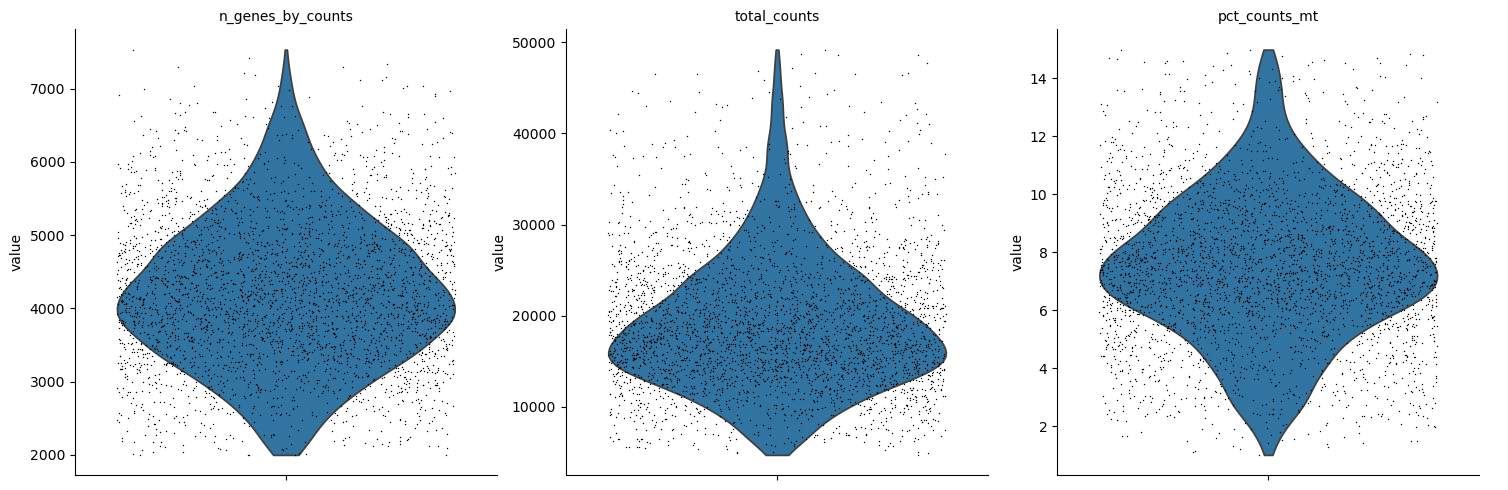

In [11]:
sc.pl.violin(
    control,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

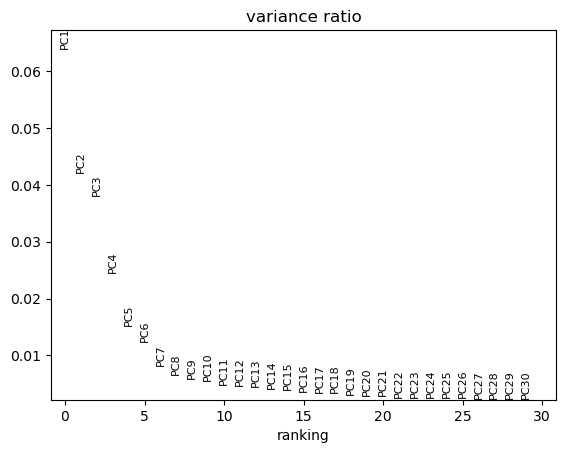

In [12]:
control_umap = sc.tl.pca(control, n_comps=30, copy=True)
sc.pl.pca_variance_ratio(control_umap, n_pcs=30)

# neighbours
sc.pp.neighbors(control_umap, n_neighbors=15, n_pcs=30)

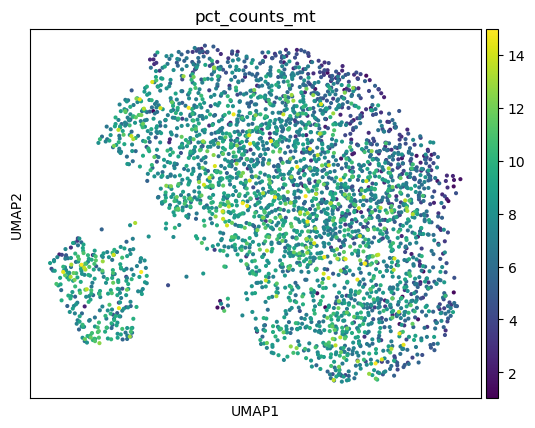

In [13]:
#UMAP
sc.tl.umap(control_umap)
sc.pl.umap(control_umap, color='pct_counts_mt')

In [14]:
control_umap

AnnData object with n_obs × n_vars = 3422 × 21786
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet', 'doublet_score', 'sample'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'umap', 'sample_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'norm'
    obsp: 'distances', 'connectivities'

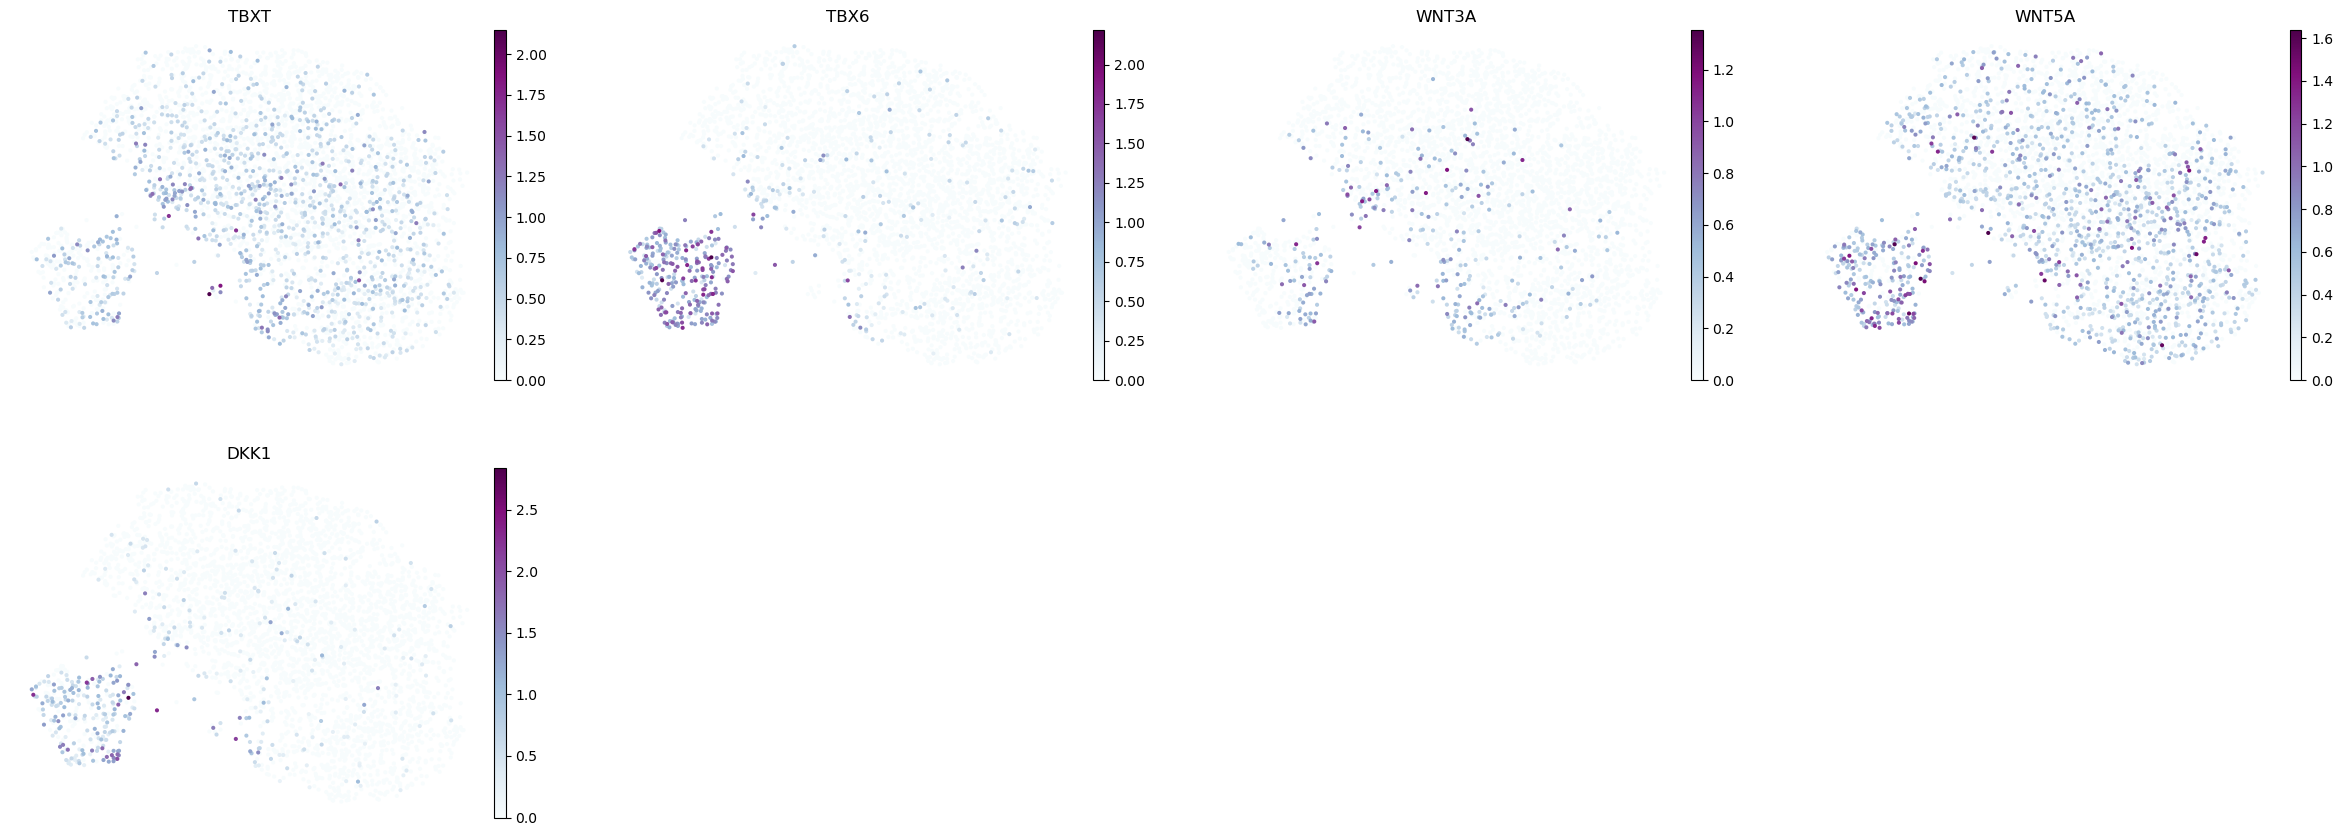

In [15]:
# sc.pl.umap(control_umap, color=["TBX6", "TBXT", "SOX2"], use_raw=False)
# sc.pl.umap(control_umap, color=['WNT3A', 'WNT5A', 'DKK1'], use_raw=False, color_map='BuPu')
# sc.pl.umap(control_umap, color=['NOTCH2', 'NOTCH3', 'DLL1', "DLL3"], use_raw=False, color_map='BuPu')
# sc.pl.umap(control_umap, color=['FGF2', 'LEF1', 'CDX2', 'FGF8'], use_raw=False, color_map='BuPu')
# sc.pl.umap(control_umap, color=['TBXT', 'NEFM','SOX2'], use_raw=False, color_map='BuPu')

# Generate the UMAP plot without displaying it
ax = sc.pl.umap(control_umap, color=['TBXT', 'TBX6', 'WNT3A', 'WNT5A', 'DKK1'], use_raw=False, color_map='BuPu', show=False)

# If multiple axes are returned (one for each gene), iterate over them
if isinstance(ax, list):
    for a in ax:
        a.axis('off')
else:
    ax.axis('off')

# Display the plot
plt.show()

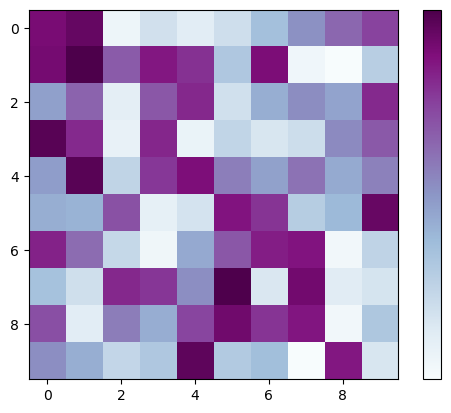

In [16]:
data = np.random.rand(10, 10)
img = plt.imshow(data, cmap='BuPu')

# Add a colorbar
cbar = plt.colorbar(img)

# Remove tick labels
cbar.set_ticks([])

# Display the plot
plt.show()

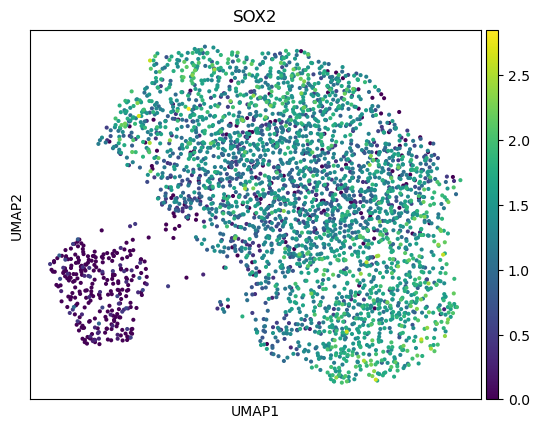

In [17]:
### coexpression
gene1 = 'TBXT'
gene2 = 'SOX2'

# control_umap.obs['SOX2'] = (control_umap.layers['raw'][:,'{}'.format(gene1)].X.todense() > 0) & (control_umap.layers['raw'][:,'{}'.format(gene2)].X.todense() > 0)
sc.pl.umap(control_umap, color='SOX2', use_raw=False)
# print(control_umap.var['TBXT'])

## Clustering
In scRNA-seq data analysis, we describe cellular structure in our dataset with finding cell identities that relate to known cell states or cell cycle stages. This process is usually called cell identity annotation. For this purpose, we structure cells into clusters to infer the identity of similar cells. Clustering itself is a common unsupervised machine learning problem. We can derive clusters by minimizing the intra-cluster distance in the reduced expression space.

The Leiden algorithm is as an improved version of the Louvain algorithm which outperformed other clustering methods for single-cell RNA-seq data analysis 

The default resolution parameter in scanpy is 1.0. However, in many cases the analyst may want to try different resolution parameters to control the coarseness of the clustering. Hence, we recommend to save the clustering result under a specified key which indicates the selected resolution.

In [18]:
sc.tl.leiden(control_umap, key_added="leiden_res0_1", resolution=0.1)
sc.tl.leiden(control_umap, key_added="leiden_res0_8", resolution=0.8)
sc.tl.leiden(control_umap, key_added="leiden_res1", resolution=1.0)
sc.tl.leiden(control_umap, key_added="leiden_res2", resolution=2.0)
sc.tl.leiden(control_umap, key_added="leiden_res3", resolution=3.0)

/var/folders/l6/7jpz7klj03q1vh5gplwyx4vm0000gn/T/ipykernel_24643/508802982.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(control_umap, key_added="leiden_res0_1", resolution=0.1)


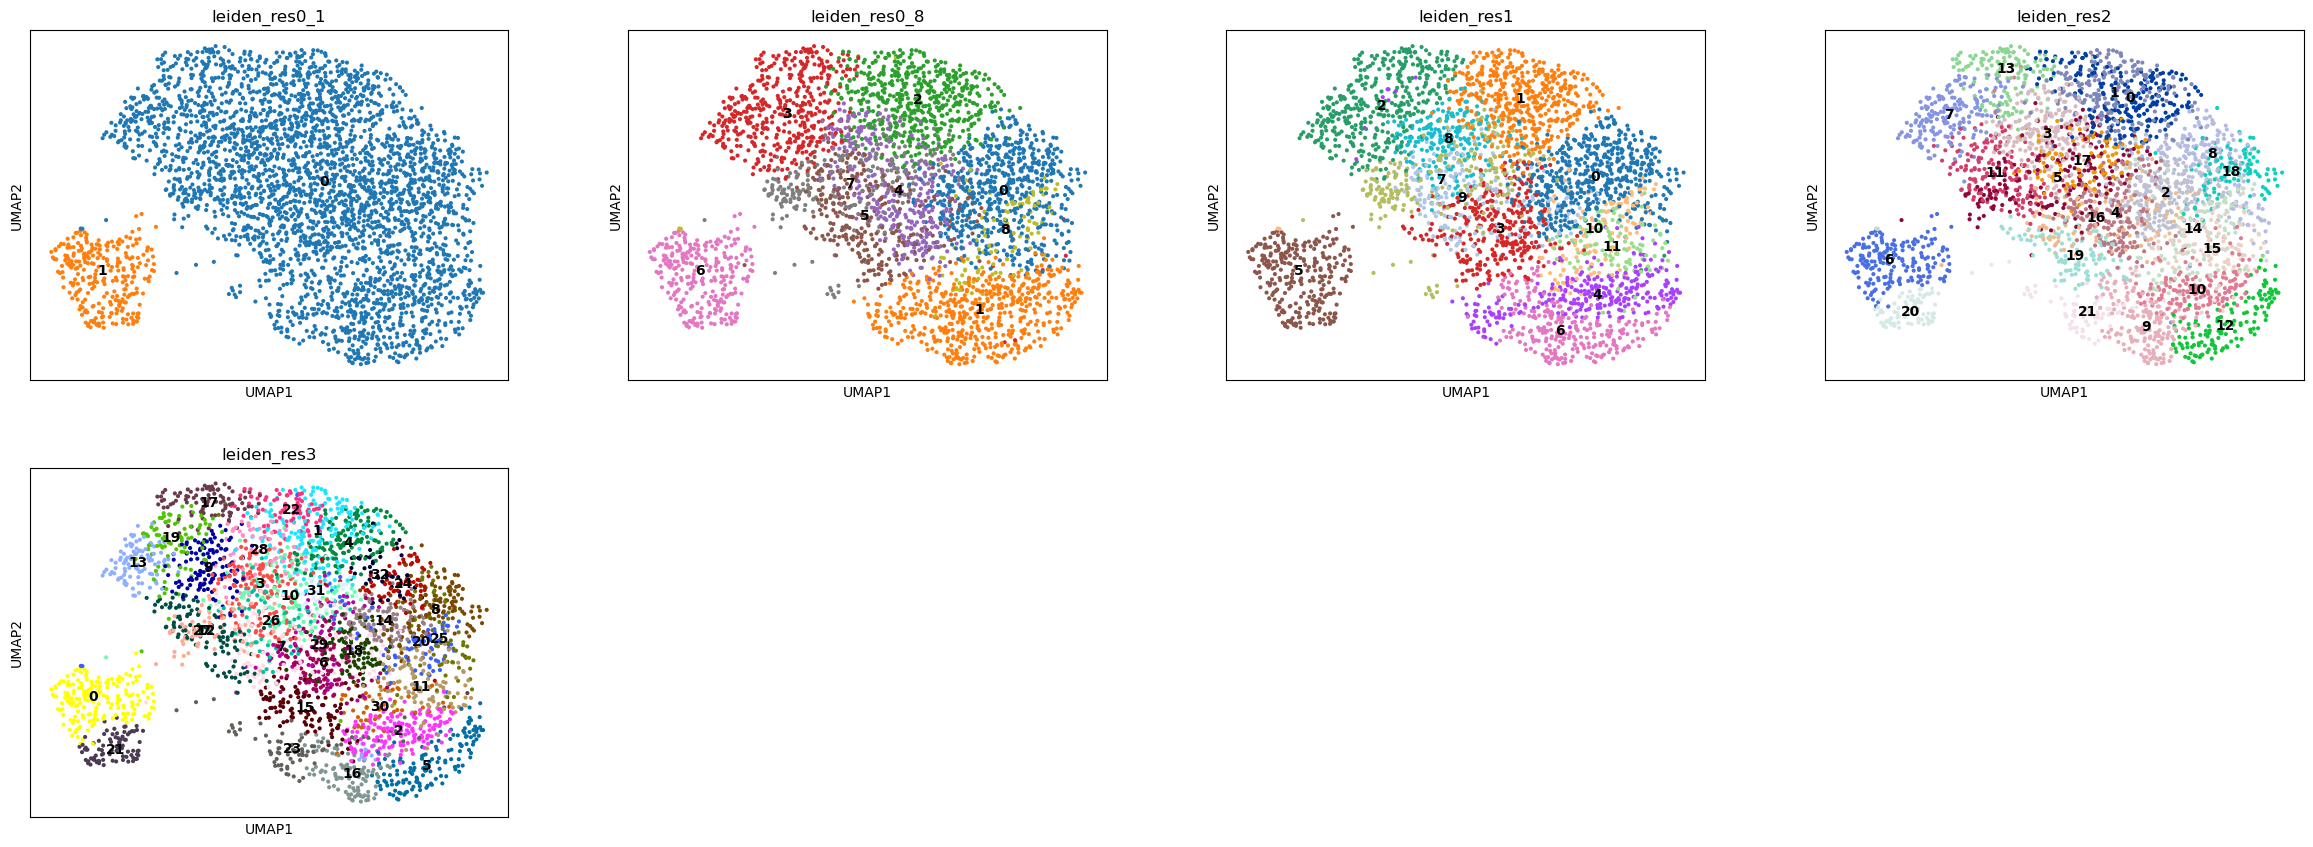

In [19]:
sc.pl.umap(
    control_umap,
    color=["leiden_res0_1", "leiden_res0_8", "leiden_res1","leiden_res2", "leiden_res3"],
    legend_loc="on data",
)

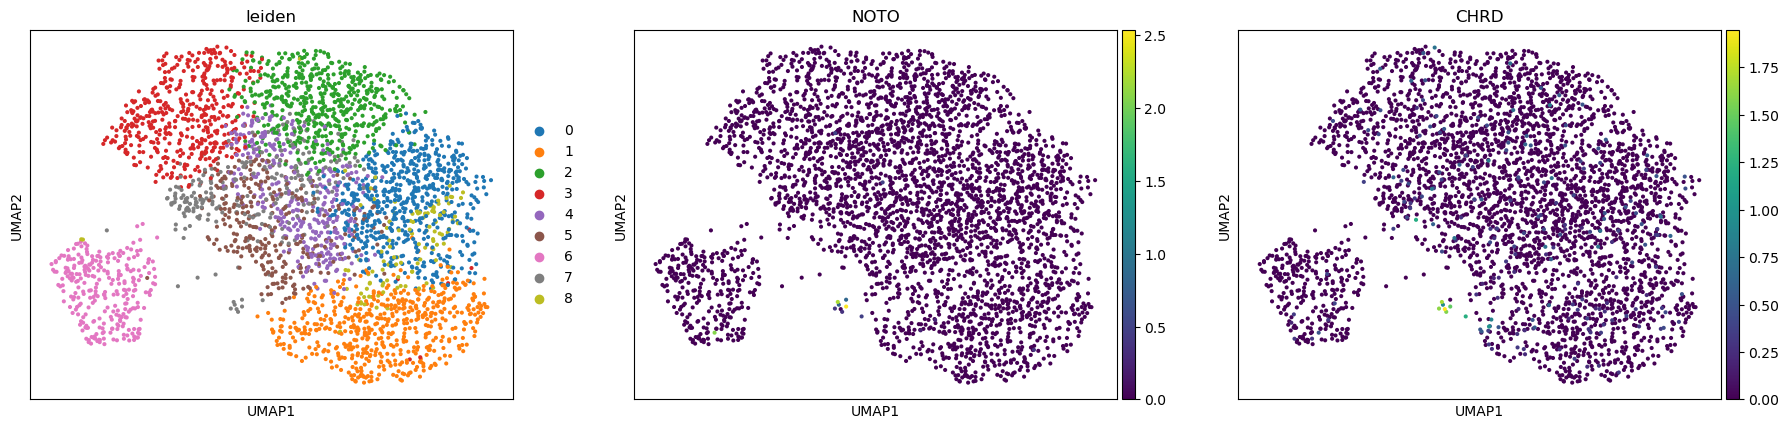

In [20]:
sc.tl.leiden(control_umap, resolution=0.8)
sc.pl.umap(control_umap, color=["leiden", "NOTO", "CHRD"])

In [21]:
control_umap

AnnData object with n_obs × n_vars = 3422 × 21786
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet', 'doublet_score', 'sample', 'leiden_res0_1', 'leiden_res0_8', 'leiden_res1', 'leiden_res2', 'leiden_res3', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'umap', 'sample_colors', 'log1p', 'hvg', 'leiden_res0_1', 'leiden_res0_8', 'leiden_res1', 'leiden_res2', 'leiden_res3', 'leiden_res0_1_colors', 'leiden_res0_8_colors', 'leiden_res1_colors', 'leiden_res2_colors', 'leiden_res3_colors', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'norm'


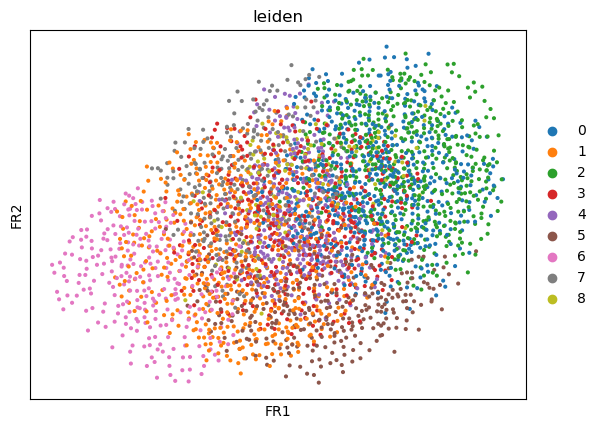

In [22]:
#Force-directed layout ?
sc.tl.draw_graph(control_umap, layout="fa", init_pos="X_umap")
sc.pl.draw_graph(control_umap, color="leiden", use_raw=False)

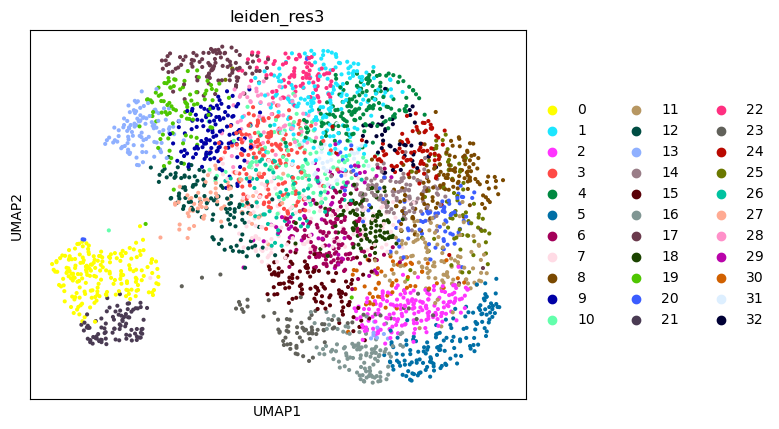

In [23]:
sc.pl.umap(control_umap, color="leiden_res3")

#### Annotation

categories: 0, 1, 2, etc.
var_group_labels: posterior neural, anterior neural, PSM, etc.


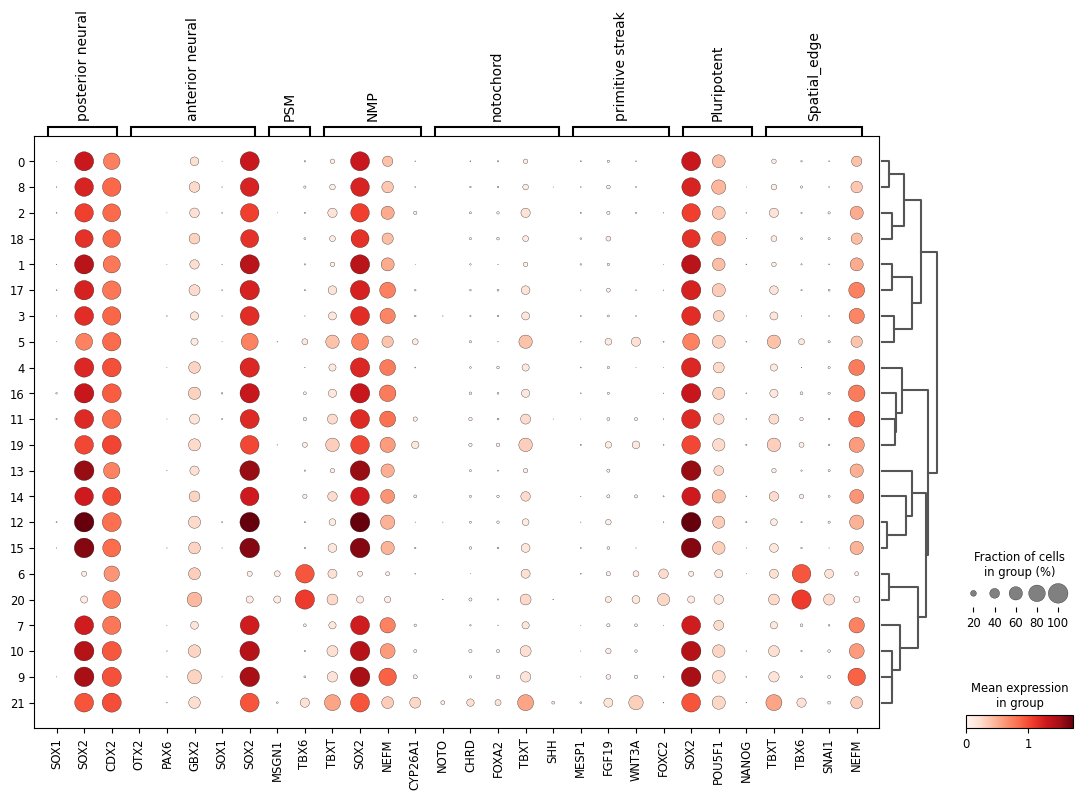

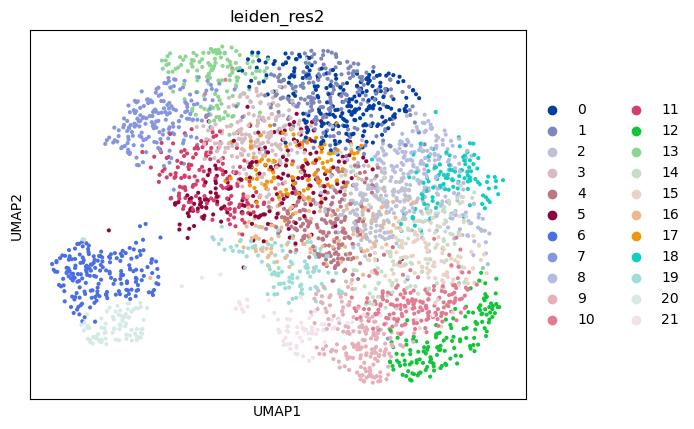

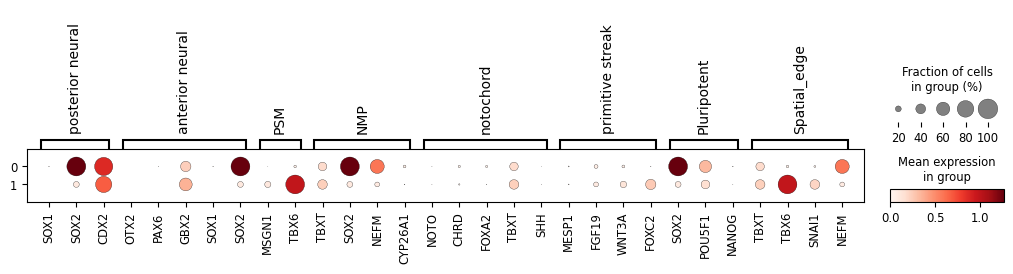

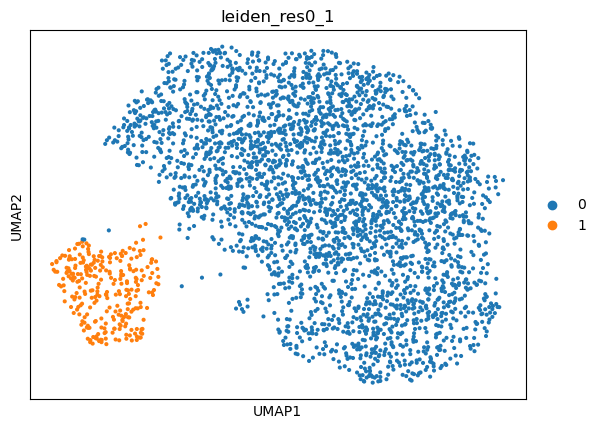

In [24]:
# Marker genes

marker_genes_dict = {
    "posterior neural": ["SOX1", "SOX2", "CDX2"],
    "anterior neural": ["OTX2", "PAX6", "GBX2","SOX1", "SOX2"],
    "PSM": ["MSGN1", "TBX6"],
    "NMP" : ["TBXT", "SOX2", "NEFM", "CYP26A1"],
    "notochord": ["NOTO", "CHRD", "FOXA2", "TBXT", 'SHH'],
    "primitive streak": ["MESP1", "FGF19", "WNT3A", 'FOXC2'],
    "Pluripotent": ["SOX2", "POU5F1", "NANOG"],
    "Spatial_edge": ["TBXT", "TBX6", 'SNAI1', 'NEFM'],
}

#checking expression of marker genes
sc.pl.dotplot(control_umap, marker_genes_dict, "leiden_res2", dendrogram=True)
sc.pl.umap(control_umap, color=["leiden_res2"])
sc.pl.dotplot(control_umap, marker_genes_dict, "leiden_res0_1", dendrogram=True)
sc.pl.umap(control_umap, color=["leiden_res0_1"])


In [25]:
#Annotation
annotation_dict_1 = {
    "21" : "Notochord",
    "5" : "PS",
    "19" : "PS",
    "4" : "PSM",
    "20" : "PSM",
    "12" : "Neural",
    "15" : "Neural",
    "16" : "Neural",
    "3" : "Neural",
    "11" : "Neural",
    "13" : "NMP",
    "14" : "hESC",
    "6" : "NMP",
    "7" : "NMP",
    "8" : "NMP",
    "9" : "NMP",
    "10" : "NMP",
    "17" : "NMP",
    "18" : "hESC",
    "0" : "NMP", 
    "1" : "NMP",
    "2" : "NMP",
}

control_umap.obs['new_clusters'] = (
    control_umap.obs['leiden_res2']
    .map(annotation_dict_1)
    .astype('category')
)


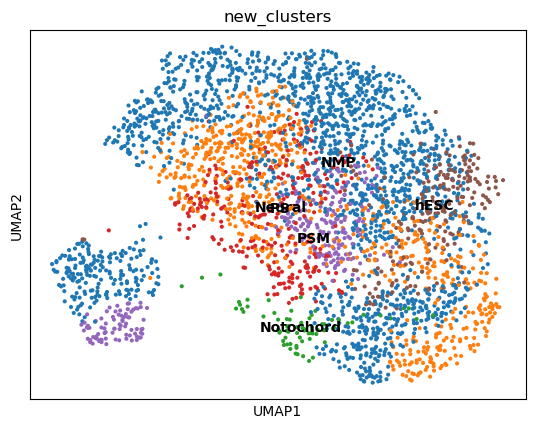

categories: NMP, Neural, Notochord, etc.
var_group_labels: posterior neural, anterior neural, PSM, etc.


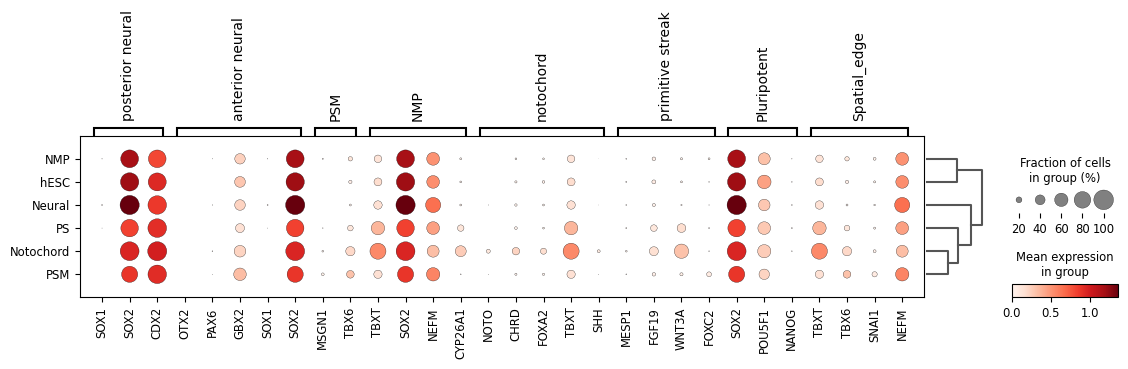

In [26]:
sc.pl.umap(control_umap, color=["new_clusters"], legend_loc="on data")
sc.pl.dotplot(control_umap, marker_genes_dict, "new_clusters", dendrogram=True)